# Análisis Exploratorio de Datos

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
df=pd.read_csv("../data/credit_risk_dataset.csv")
df.head(5)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


### Contexto

El presente proyecto tiene como objetivo analizar y predecir el **riesgo de incumplimiento de préstamos** a partir de datos simulados de un buró de crédito.  
El dataset incluye información sobre las características personales, laborales y financieras de los solicitantes, como **edad**, **ingreso**, **tipo de vivienda**, **monto** y **tasa del préstamo**.  
Con esta información, se entrena un modelo de **Machine Learning** que permite estimar la probabilidad de **default** y explicar los factores que influyen en la decisión mediante técnicas de **XAI (Explainable Artificial Intelligence)**.


### Diccionario de Datos

- **person_age** — Edad del solicitante  
- **person_income** — Ingreso anual del solicitante  
- **person_home_ownership** — Tipo de propiedad de vivienda  
- **person_emp_length** — Años de antigüedad laboral  
- **loan_intent** — Motivo del préstamo  
- **loan_grade** — Calificación del préstamo  
- **loan_amnt** — Monto solicitado  
- **loan_int_rate** — Tasa de interés del préstamo  
- **loan_status** — Estado del préstamo (0 = no default, 1 = default)  
- **loan_percent_income** — Porcentaje del ingreso destinado al préstamo  
- **cb_person_default_on_file** — Historial de incumplimiento en archivo crediticio  
- **cb_preson_cred_hist_length** — Longitud del historial crediticio (en años)  

In [2]:
print("Total de registros: ",df.shape[0])
print("Total de columnas: ", df.shape[1])

Total de registros:  32581
Total de columnas:  12


In [3]:
# Información del DataFrame
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [4]:
# Análisis de valores faltantes
missing_df = pd.DataFrame({
    'Feature': df.columns,
    'Missing Values': df.isnull().sum().values,
    'Percentage': (df.isnull().sum().values / len(df)) * 100
})

missing_df = missing_df[missing_df['Missing Values'] > 0]
missing_df = missing_df.sort_values(by='Missing Values', ascending=False)
missing_df

,Feature,Missing Values,Percentage
7,loan_int_rate,3116,9.563856
3,person_emp_length,895,2.747000


In [ ]:
print("Número de registros duplicados:",df.duplicated().sum())

Número de registroe duplicados: 165


In [6]:
print("Descripción estadística de las variables numéricas:")
df.describe()

Descripción estadística de las variables numéricas:


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


- Valores atípicos: se observan edades (144 años) y años de trabajo (123) imposibles → se aplicará filtrado o eliminación de outliers.
- Ingresos extremadamente altos: algunos valores superan los 6 millones, lo que puede distorsionar las métricas → se usará winsorización o recorte de valores extremos.
- Datos faltantes: la variable loan_int_rate presenta nulos, por lo que se realizará imputación según la distribución o media por grupo.
- Relación préstamo/ingreso: aunque la mayoría es coherente, existen casos cercanos al 80% → se revisará con detección de valores extremos o normalización.

<Axes: title={'center': "Distribución de la variable objetivo 'loan_status'"}, xlabel='loan_status'>

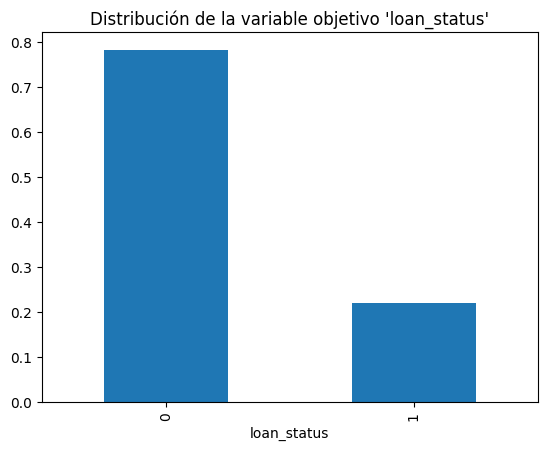

In [7]:
df['loan_status'].value_counts(normalize=True).plot(kind="bar", title="Distribución de la variable objetivo 'loan_status'")

Se visualiza una considerada desproporción entre las clases, se considerará aplicar técnicas avanzadas de balanceo de datos.

## Análisis númerico

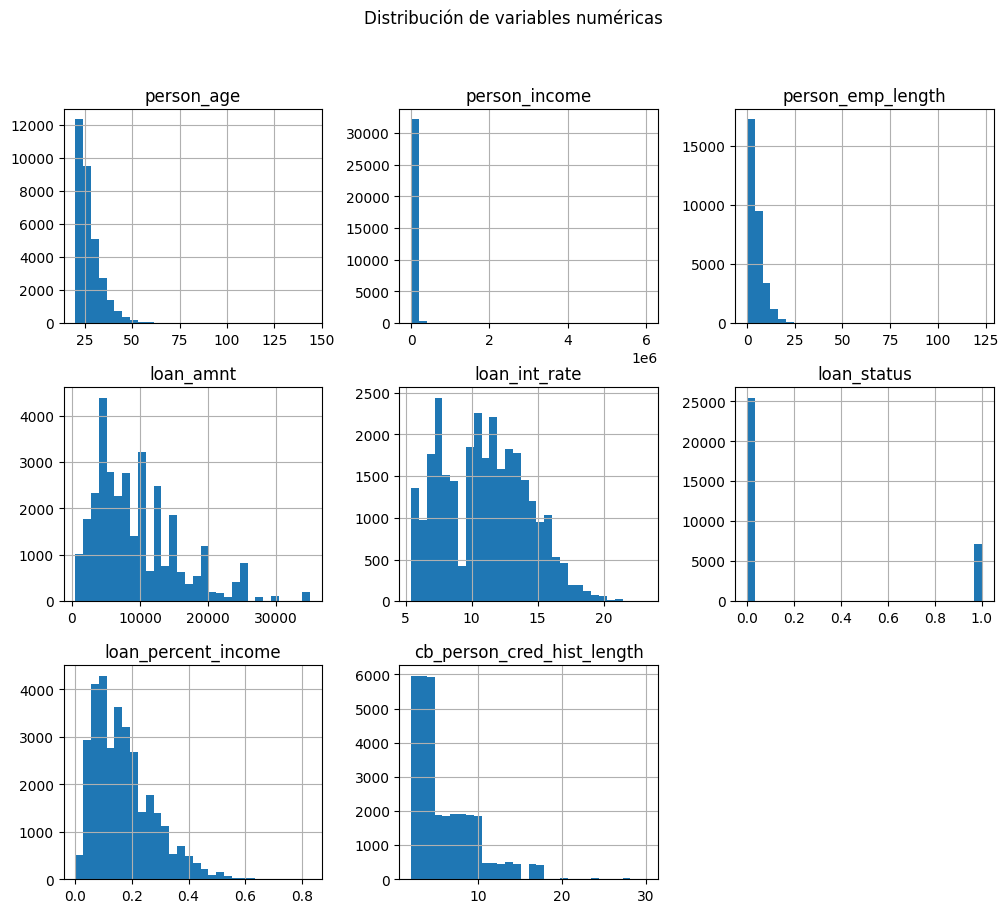

In [8]:
df.hist(figsize=(12, 10), bins=30)
plt.suptitle("Distribución de variables numéricas")
plt.show()

- Casi todas las variables (ingresos, préstamos, edad, etc.) tienen una distribución con cola larga a la derecha, concentrándose la mayoría de los datos en valores bajos. Esto requiere aplicar transformaciones (ej: logarítmica) antes de usar modelos lineales.
- La presencia de valores atípicos muy altos, especialmente en person_income (ingresos), distorsiona la media y la varianza. Es crucial limitar o tratar estos valores (ej: método IQR) para evitar que impacten negativamente la robustez del modelo.

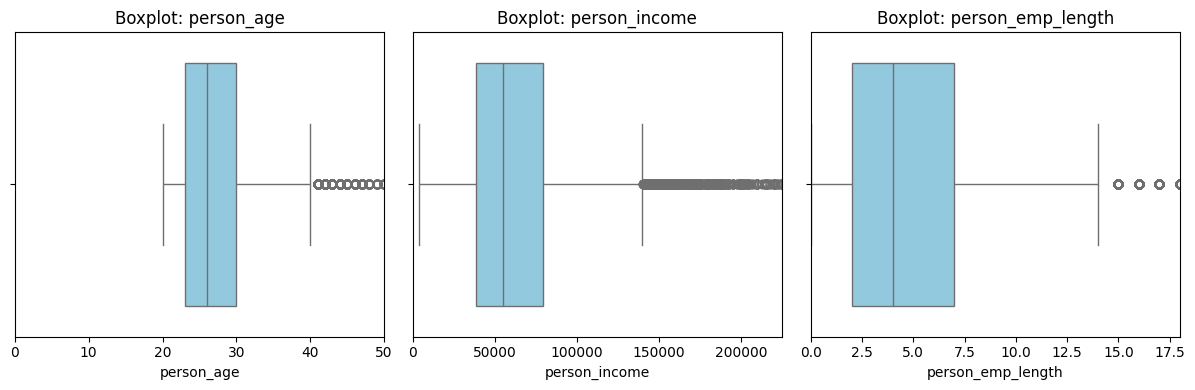

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Variables críticas por outliers
vars_criticas = [
    'person_age',
    'person_income',
    'person_emp_length'
]

plt.figure(figsize=(12, 4))
for i, var in enumerate(vars_criticas, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x=df[var], color="skyblue")
    max_val = df[var].quantile(0.99)
    plt.xlim(0, max_val)
    plt.title(f"Boxplot: {var}")
plt.tight_layout()
plt.show()


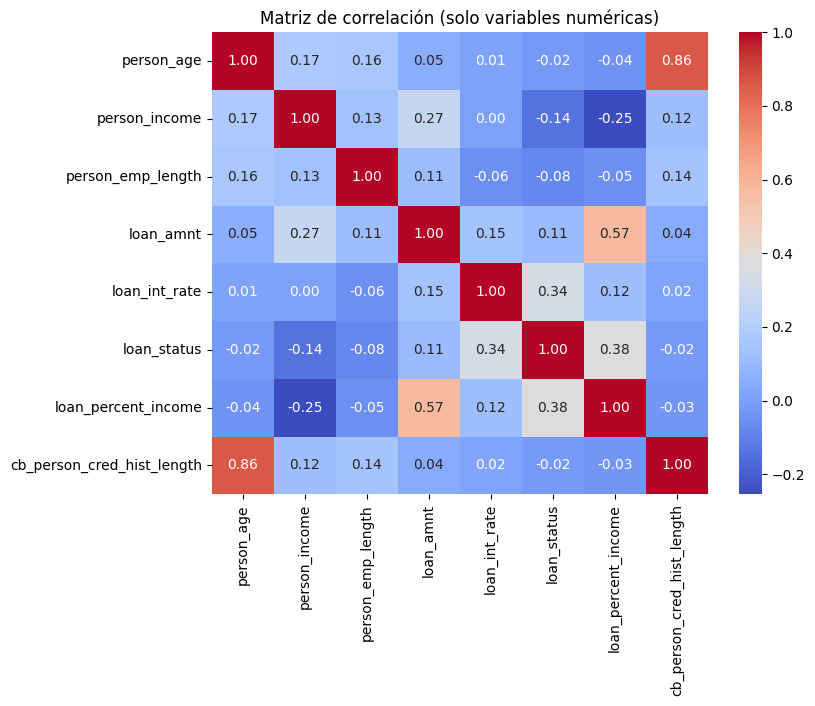

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_df = df.select_dtypes(include=['int64', 'float64'])

corr = numeric_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación (solo variables numéricas)")
plt.show()

## Análisis categórico

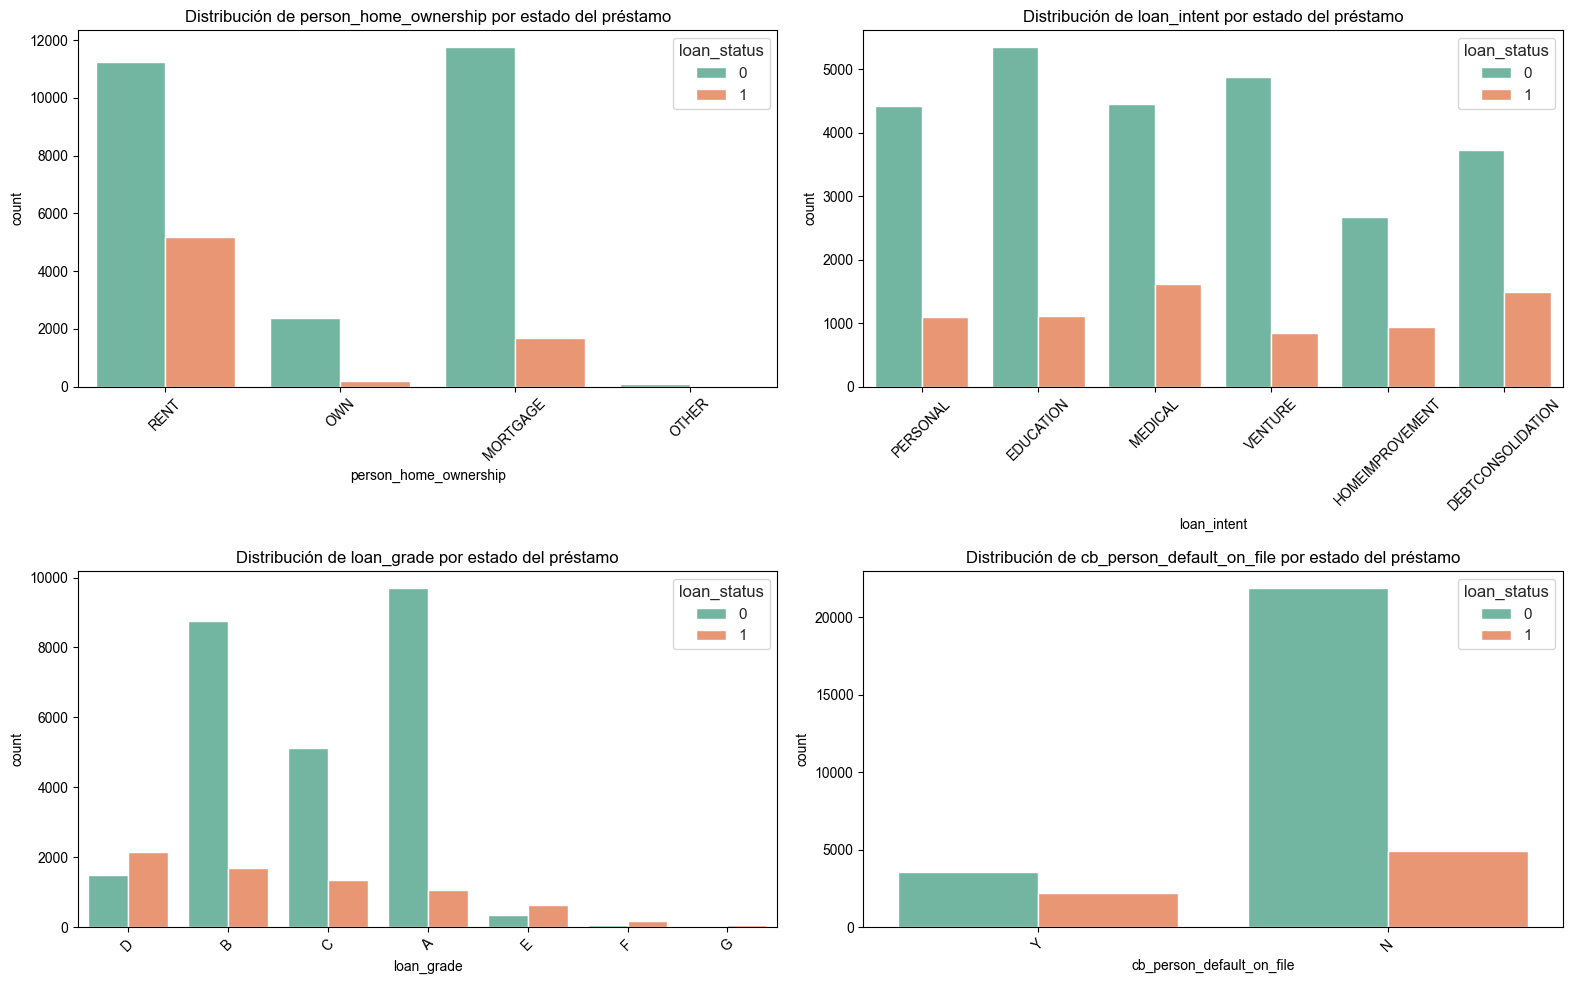

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Variables categóricas
categorical_vars = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

# Configuración de la cuadrícula 2x2
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

sns.set(style="whitegrid")

# Graficar cada variable en su respectivo eje
for i, var in enumerate(categorical_vars):
    sns.countplot(data=df, x=var, hue='loan_status', palette='Set2', ax=axes[i])
    axes[i].set_title(f"Distribución de {var} por estado del préstamo")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

- Los préstamos personales y educativos presentan más incumplimientos (≈60%).
- Quienes alquilan (RENT) o tienen hipoteca (MORTGAGE) incumplen más que los propietarios (OWN).
- A medida que el grado baja (de A→E), el riesgo aumenta; los grados D y B superan en incumplimiento.
- Hubo un incremento en inclumplimiento de clientes que no contaban con historial de inpago.

# Preprocesamiento

In [12]:
# Imputación de valores faltantes
df['loan_int_rate'].fillna(df['loan_int_rate'].median(), inplace=True)
df['person_emp_length'].fillna(df['person_emp_length'].median(), inplace=True)

In [13]:
# Eliminar duplicados
df.drop_duplicates(inplace=True)

In [14]:
# Tratamiento de outliers usando IQR
variables = ['person_age', 'person_income', 'person_emp_length']

for var in variables:
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    mediana = df[var].median()
    media = df[var].mean()
    df[var] = df[var].apply(lambda x: mediana if x < lower_bound else media if x > upper_bound else x)

In [15]:
# Agrupación de categorías raras
categorical_nominal = ['person_home_ownership', 'loan_intent', 'cb_person_default_on_file']
categorical_ordinal = ['loan_grade']  # NO se toca para rare categories

def group_rare_categories(df, cols, threshold=0.01):
    for col in cols:
        freq = df[col].value_counts(normalize=True)
        rare_categories = freq[freq < threshold].index
        df[col] = df[col].apply(lambda x: 'Otros' if x in rare_categories else x)
    return df

# Solo aplicar a nominales
df = group_rare_categories(df, categorical_nominal)

# Asegurar que loan_grade solo tenga categorías válidas
valid_grades = ['A','B','C','D','E','F','G']
df['loan_grade'] = df['loan_grade'].apply(lambda x: x if x in valid_grades else 'G')

In [ ]:
# Pipeline de preprocesamiento
import pandas as pd
from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

# Columnas
numeric_features = [
    'person_age', 'person_income', 'person_emp_length',
    'loan_amnt', 'loan_int_rate', 'loan_percent_income',
    'cb_person_cred_hist_length'
]

categorical_nominal = ['person_home_ownership', 'loan_intent', 'cb_person_default_on_file']
categorical_ordinal = ['loan_grade']

# Preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('power', PowerTransformer(method='yeo-johnson')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        
        ('cat_nom', OneHotEncoder(handle_unknown='ignore'), categorical_nominal),
        
        ('cat_ord', OrdinalEncoder(categories=[['A','B','C','D','E','F','G']]), categorical_ordinal)
    ]
)

# Pipeline solo para transformación
transformer_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Ajustar el pipeline con los datos
X = df.drop('loan_status', axis=1)
transformer_pipeline.fit(X)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('power',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_cred_hist_length']),
                                                 ('cat_nom',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['person_home_ownership',
                                                   'loan_intent',
                                                   'cb_person_default_on_file']),
                                                 ('cat_ord',
                                                  OrdinalEncoder(categories=[['A',
                                                                              'B',
                                                                              'C',
                                                                              'D',
                                                                              'E',
                                                                              'F',
                                                                              'G']]),
                                                  ['loan_grade'])]))])

In [ ]:
# Transformar el dataset
X_transformed = transformer_pipeline.transform(X)

# Guardar el transformador
joblib.dump(transformer_pipeline, '../models/transformador.pkl')

# Obtener nombres de columnas transformadas
feature_names = (
    numeric_features +
    list(transformer_pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_nominal)) +
    categorical_ordinal
)

# Crear DataFrame transformado e incluir loan_status
df_transformed = pd.DataFrame(X_transformed, columns=feature_names)
df_transformed['loan_status'] = df['loan_status'].values  # Añadir la columna objetivo

# Guardar dataset transformado
df_transformed.to_csv('../data/dataset_transformado.csv', index=False)

print("Transformador y dataset transformado (con loan_status) guardados correctamente.")

✅ Transformador y dataset transformado (con loan_status) guardados correctamente.


In [19]:
df_transformed.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OWN,person_home_ownership_Otros,...,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_N,cb_person_default_on_file_Y,loan_grade,loan_status
0,-1.359495,0.146425,0.290655,2.536826,1.542584,2.369138,-0.707592,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,1
1,-1.830518,-2.759719,0.353305,-2.397391,0.099330,-0.619260,-1.446108,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0
2,-0.265733,-2.759719,-1.075468,-0.538105,0.636834,2.321462,-0.707592,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,1
3,-0.947703,0.377641,0.070670,2.536826,1.323138,2.216757,-1.446108,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,1
4,-0.585668,-0.027329,1.060970,2.536826,1.049828,2.270747,-0.203457,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,1


# Análisis de Perfil del cliente default

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar los que no pagaron
df_default = df[df['loan_status'] == 1]

perfil_numerico = df_default[numeric_features].agg(['mean', 'median', 'min', 'max']).T
print("Perfil numérico (Default):")
perfil_numerico

Perfil numérico (Default):


,mean,median,min,max
person_age,26.607638,26.00,20.00,40.00
person_income,46133.350018,41682.00,4000.00,140004.00
person_emp_length,3.852722,3.00,0.00,14.00
loan_amnt,10857.479898,9600.00,900.00,35000.00
loan_int_rate,12.879897,12.99,5.42,23.22
loan_percent_income,0.246906,0.24,0.01,0.78
cb_person_cred_hist_length,5.684723,4.00,2.00,30.00


El cliente en default suele tener lo siguiente:
- Edad: Jóvenes (promedio 26 años).
- Ingreso: Moderado ($46K en promedio).
- Antigüedad laboral: Baja (≈4 años).
- Monto del préstamo: Alto en relación al ingreso (≈$10.8K).
- Tasa de interés: Elevada (≈12.9%).
- Porcentaje del ingreso comprometido: Alto (≈25%, con casos extremos hasta 78%).
- Historial crediticio: Corto (≈6 años).

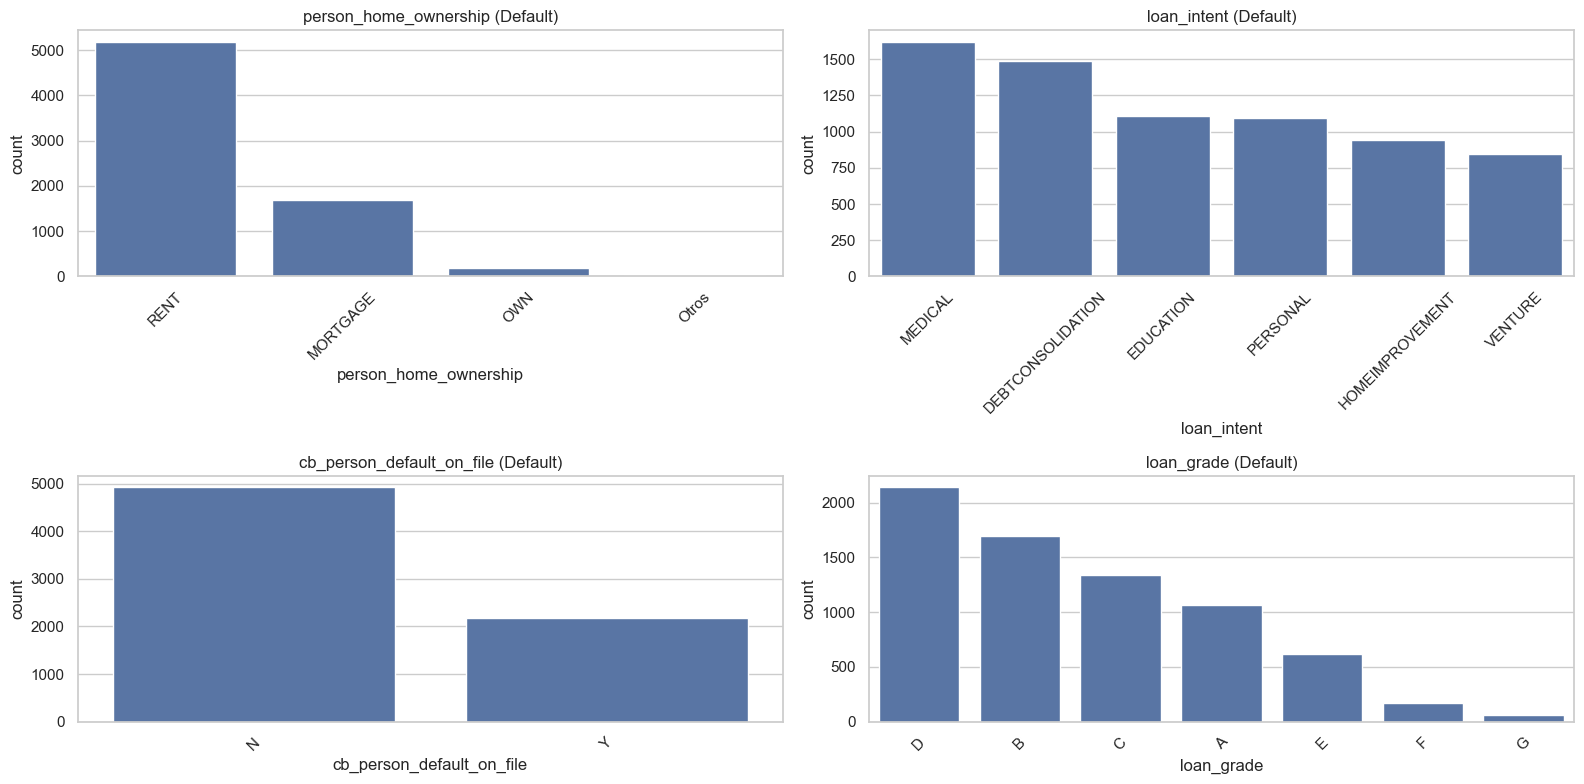

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar los que no pagaron
df_default = df[df['loan_status'] == 1]

# Columnas categóricas
categorical_cols = categorical_nominal + categorical_ordinal

# Configuración de la cuadrícula 2x2
n_rows, n_cols = 2, 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 8))
axes = axes.flatten()

sns.set(style="whitegrid")

# Graficar solo las primeras 4 columnas categóricas
for i, col in enumerate(categorical_cols[:4]):
    sns.countplot(x=col, data=df_default, order=df_default[col].value_counts().index, ax=axes[i])
    axes[i].set_title(f"{col} (Default)")
    axes[i].tick_params(axis='x', rotation=45)

# Ocultar ejes vacíos si sobran
for j in range(len(categorical_cols[:4]), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

El cliente en default típicamente:

- Alquila vivienda (RENT).
- Solicita préstamos para salud o consolidación de deuda.
- No siempre tiene historial previo de incumplimiento.
- Pertenece a grados de riesgo medio-bajo (D, B).